# 🛠 08. Introduction to NLP (Natural Language Processing) in TensorFlow Exercises

1. Rebuild, compile and train `model_1`, `model_2` and `model_5` using the Keras Sequential API instead of the Functional API.

2. Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?

3. Try fine-tuning the TF Hub Universal Sentence Encoder model by setting training=True when instantiating it as a Keras layer.

  We can use this encoding layer in place of our text_vectorizer and embedding layer
    
    sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string trainable=True) # turn training on to fine-tune the TensorFlow Hub model

4. Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the sample_submission.csv file from Kaggle (see the Files tab in Colab for what the sample_submission.csv file looks like). Once you've done this, make a submission to the Kaggle competition, how did your model perform?

5. Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?

6. Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.    

In [1]:
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes

## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys, make_confusion_matrix

--2025-01-20 03:18:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-20 03:18:14 (120 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset



In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip


# Unzip data
unzip_data("nlp_getting_started.zip")

!rm "nlp_getting_started.zip"

--2025-01-20 03:18:25--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 142.250.99.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2025-01-20 03:18:25 (107 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_df.target.value_counts()

,count
target,
0,4342
1,3271


## Split data into training and validation sets

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # Use 10% of training data for validation split
                                                                            random_state=42)

In [10]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

## Converting text into numbers

### Text Vectorization (Tokenization)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [12]:
max_vocab_length = 20000 # Max number of words to have in our vocabulary
max_length = 50

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [13]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [14]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [15]:
import random
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence} \n\nVectorized version: ")
text_vectorizer([random_sentence])

Original text:
 Grace: here are damage levels USA style.. #Taiwan #China #world hurricane/typhoon ratings/categories defined again http://t.co/OdYdT9QPk1 

Vectorized version: 


<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[ 2444,   140,    22,   233,  2065,   799,  1961,  1248,   862,
          107, 12351,  9343, 18338,   282, 13724,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]])>

In [16]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # Get all the unique words in ourr training data
top_5_words = words_in_vocab[:5] # Get the most common words
bottom_5_words = words_in_vocab[-5:] # Get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 20000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['attending', 'attendees', 'attended', 'attend', 'attempted']


## Creating an Embedding using an Embeding Layer

In [17]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # Set input shape
                             output_dim=256, # Output shape
                             input_length=max_length # How long each input
                             )
embedding

In [18]:
random_sentence = random.choice(train_sentences)
print(f"Original text: \n {random_sentence}\n\n Embedding version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text: 
 Refugio oil spill may have been costlier bigger than projected http://t.co/BIEYgUqpB1

 Embedding version:


<tf.Tensor: shape=(1, 50, 256), dtype=float32, numpy=
array([[[-0.02970518, -0.01748637, -0.01017008, ..., -0.03282269,
          0.01436224, -0.00712965],
        [ 0.04960081, -0.03042399, -0.0371374 , ..., -0.04394679,
          0.04009512, -0.04887555],
        [-0.04809823, -0.04780149,  0.04812748, ..., -0.0448593 ,
          0.00793761,  0.02227538],
        ...,
        [-0.03176864, -0.00437478, -0.02074316, ..., -0.01150556,
         -0.023398  , -0.04656061],
        [-0.03176864, -0.00437478, -0.02074316, ..., -0.01150556,
         -0.023398  , -0.04656061],
        [-0.03176864, -0.00437478, -0.02074316, ..., -0.01150556,
         -0.023398  , -0.04656061]]], dtype=float32)>

In [19]:
# Check out single token's embedding
sample_embed[0][0].shape, random_sentence

(TensorShape([256]),
 'Refugio oil spill may have been costlier bigger than projected http://t.co/BIEYgUqpB1')

In [20]:
# # Create a Keras Layer using the USE pretrained layer from tensorflow hub
# sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
#                                         input_shape=[],
#                                         dtype=tf.string,
#                                         trainable=False,
#                                         name="USE")
# # Create model using the Sequential API
# model_6 = tf.keras.Sequential([
#      sentence_encoder_layer,
#     # layers.Dense(64, activation="relu"),
#     layers.Dense(1, activation="sigmoid")
# ], name="model_6_USE")
# # Compile
# model_6.compile(loss="binary_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accuracy"])

# # Get the summary
# model_6.summary()
# # Train a classifier on top of USE pretrained embeddings
# model_6_history = model_6.fit(train_sentences,
#                               train_labels,
#                               epochs=5,
#                               validation_data=(val_sentences, val_labels))

## 1. Rebuild, compile and train `model_1`, `model_2` and `model_5` using the Keras Sequential API instead of the Functional API.

In [21]:
from tensorflow.keras import layers
model_1 = tf.keras.Sequential([
    layers.Input(shape=(1, ), dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.GlobalMaxPool1D(),
    layers.Dense(1, activation="sigmoid")
])

In [22]:
# Compile
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get the summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 50)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 50, 256)           5120000   
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 5120257 (19.53 MB)
Trainable params: 5120257 (19.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# Train a classifier on top of USE pretrained embeddings
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 20s 71ms/step - loss: 0.6229 - accuracy: 0.6706 - val_loss: 0.5389 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4182 - accuracy: 0.8516 - val_loss: 0.4535 - val_accuracy: 0.7979
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2704 - accuracy: 0.9034 - val_loss: 0.4553 - val_accuracy: 0.8031
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1720 - accuracy: 0.9480 - val_loss: 0.4733 - val_accuracy: 0.8005
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1076 - accuracy: 0.9731 - val_loss: 0.5041 - val_accuracy: 0.7992


### Model 2

In [24]:
from tensorflow.keras import layers
model_2 = tf.keras.Sequential([
    layers.Input(shape=(1, ), dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(1, activation="sigmoid")
])

In [25]:
# Compile
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get the summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 50)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 50, 256)           5120000   
                                                                 
 lstm (LSTM)                 (None, 50, 128)           197120    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5366593 (20.47 MB)
Trainable params: 5366593 (20.47 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [26]:
# Train a classifier on top of USE pretrained embeddings
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 16s 53ms/step - loss: 0.5862 - accuracy: 0.6933 - val_loss: 0.5772 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.5024 - accuracy: 0.7704 - val_loss: 0.5916 - val_accuracy: 0.6798
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4898 - accuracy: 0.7800 - val_loss: 0.5944 - val_accuracy: 0.6995
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4599 - accuracy: 0.8015 - val_loss: 0.5947 - val_accuracy: 0.7087
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4386 - accuracy: 0.8154 - val_loss: 0.6029 - val_accuracy: 0.7139


### Model 5

In [27]:
model_5 = tf.keras.Sequential([
    layers.Input(shape=(1, ), dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.Conv1D(filters=32, kernel_size=5, activation="relu"),
    layers.GlobalMaxPool1D(),
    layers.Dense(1, activation="sigmoid")
])

In [28]:
# Compile
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get the summary
model_5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 50)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 50, 256)           5120000   
                                                                 
 conv1d (Conv1D)             (None, 46, 32)            40992     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5161025 (19.69 MB)
Trainable params: 516

In [29]:
# Train a classifier on top of USE pretrained embeddings
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 12s 42ms/step - loss: 0.3326 - accuracy: 0.8704 - val_loss: 0.4972 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.1411 - accuracy: 0.9486 - val_loss: 0.5887 - val_accuracy: 0.7940
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0511 - accuracy: 0.9863 - val_loss: 0.6721 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0276 - accuracy: 0.9924 - val_loss: 0.7971 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0214 - accuracy: 0.9936 - val_loss: 0.8082 - val_accuracy: 0.7690


## 2. Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?

In [30]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculate model accuracy, precision, recall and f1-score of a binary classification model.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100

    # Calculate model precision, recall and f1-score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }
    return model_results

In [31]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [32]:
from tensorflow.keras import layers
model_10_percent_data = tf.keras.Sequential([
    layers.Input(shape=(1, ), dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.GlobalMaxPool1D(),
    layers.Dense(1, activation="sigmoid")
])

In [33]:
# Compile
model_10_percent_data.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Train a classifier on top of USE pretrained embeddings
model_10_percent_data_history = model_10_percent_data.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
22/22 [==============================] - 3s 125ms/step - loss: 0.6250 - accuracy: 0.8861 - val_loss: 0.6203 - val_accuracy: 0.7756
Epoch 2/5
22/22 [==============================] - 2s 86ms/step - loss: 0.5056 - accuracy: 0.9547 - val_loss: 0.5751 - val_accuracy: 0.7848
Epoch 3/5
22/22 [==============================] - 2s 69ms/step - loss: 0.4138 - accuracy: 0.9650 - val_loss: 0.5422 - val_accuracy: 0.7913
Epoch 4/5
22/22 [==============================] - 1s 52ms/step - loss: 0.3414 - accuracy: 0.9723 - val_loss: 0.5180 - val_accuracy: 0.7927
Epoch 5/5
22/22 [==============================] - 1s 30ms/step - loss: 0.2827 - accuracy: 0.9810 - val_loss: 0.5013 - val_accuracy: 0.7927


In [34]:
# Make predictions with the model trained on 10% of the data
model_10_percent_data_pred_probs = model_10_percent_data.predict(val_sentences)
model_10_percent_data_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.30193314],
       [0.51294905],
       [0.8120007 ],
       [0.25731087],
       [0.4021866 ],
       [0.8031611 ],
       [0.6712071 ],
       [0.7613938 ],
       [0.7330544 ],
       [0.370023  ]], dtype=float32)

In [35]:
model_10_percent_preds = tf.squeeze(tf.round(model_10_percent_data_pred_probs))
model_10_percent_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [36]:
import numpy as np
model_10_percent_results = calculate_results(y_true=val_labels, y_pred=np.array(model_10_percent_preds))
model_10_percent_results

{'accuracy': 79.26509186351706,
 'precision': 0.8102411127001243,
 'recall': 0.7926509186351706,
 'f1': 0.7864276869782622}

### Universal Sentence Encoder model with 10% of the training data

In [37]:
import tensorflow_hub as hub
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [38]:
model = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_USE")

# Compile model
model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model.summary()

Model: "model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [39]:
# Fit the model to the 10% training data subsets
model_une_10_percent_history = model.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
22/22 [==============================] - 6s 41ms/step - loss: 0.6667 - accuracy: 0.6934 - val_loss: 0.6437 - val_accuracy: 0.7402
Epoch 2/5
22/22 [==============================] - 0s 20ms/step - loss: 0.5901 - accuracy: 0.8161 - val_loss: 0.5797 - val_accuracy: 0.7664
Epoch 3/5
22/22 [==============================] - 0s 20ms/step - loss: 0.5105 - accuracy: 0.8204 - val_loss: 0.5285 - val_accuracy: 0.7756
Epoch 4/5
22/22 [==============================] - 0s 20ms/step - loss: 0.4514 - accuracy: 0.8219 - val_loss: 0.4996 - val_accuracy: 0.7664
Epoch 5/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4133 - accuracy: 0.8350 - val_loss: 0.4891 - val_accuracy: 0.7822


In [40]:
# Make predictions with the model trained on 10% of the data
model_pred_probs = model.predict(val_sentences)
model_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.19829974],
       [0.57785714],
       [0.9329335 ],
       [0.36384028],
       [0.547726  ],
       [0.7094357 ],
       [0.896553  ],
       [0.80209315],
       [0.85476404],
       [0.14258477]], dtype=float32)

In [41]:
model_preds = tf.squeeze(tf.round(model_pred_probs))
model_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [42]:
model_results = calculate_results(y_true=val_labels, y_pred=np.array(model_preds))
model_results

{'accuracy': 78.21522309711287,
 'precision': 0.7833242410577732,
 'recall': 0.7821522309711286,
 'f1': 0.7805300645444496}

In [43]:
combined_model_results = pd.DataFrame({
    "model_10_percent_data": model_10_percent_results,
    "model_une_10_percent": model_results
})
combined_model_results = combined_model_results.transpose()
combined_model_results

,accuracy,precision,recall,f1
model_10_percent_data,79.265092,0.810241,0.792651,0.786428
model_une_10_percent,78.215223,0.783324,0.782152,0.780530


## 3. Try fine-tuning the TF Hub Universal Sentence Encoder model by setting training=True when instantiating it as a Keras layer.

We can use this encoding layer in place of our text_vectorizer and embedding layer
    
    sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string trainable=True) # turn training on to fine-tune the TensorFlow Hub model

In [44]:
sentence_encoder_trainable_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True,
                                        name="USE_TRAINABLE")

In [45]:
model_uae_trainable = tf.keras.Sequential([
  sentence_encoder_trainable_layer,
  layers.Dense(256, activation="relu"),
  layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_USE")

# Compile model
model_uae_trainable.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                metrics=["accuracy"])

In [46]:
model_uae_trainable.summary()

Model: "model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_TRAINABLE (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 output_layer (Dense)        (None, 1)                 257       
                                                                 
Total params: 256929409 (980.11 MB)
Trainable params: 256929409 (980.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
for layer_number, layer in enumerate(model_uae_trainable.layers):
  print(layer_number, layer.name, layer.trainable)

0 USE_TRAINABLE True
1 dense_5 True
2 output_layer True


In [48]:
# Fit the model to the 100% training data subsets
model_une_100_percent_trainable_history = model_uae_trainable.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels))

Epoch 1/10
215/215 [==============================] - 122s 438ms/step - loss: 0.6684 - accuracy: 0.6376 - val_loss: 0.6463 - val_accuracy: 0.6640
Epoch 2/10
215/215 [==============================] - 28s 132ms/step - loss: 0.6079 - accuracy: 0.7526 - val_loss: 0.5833 - val_accuracy: 0.7874
Epoch 3/10
215/215 [==============================] - 25s 114ms/step - loss: 0.5341 - accuracy: 0.7973 - val_loss: 0.5175 - val_accuracy: 0.7966
Epoch 4/10
215/215 [==============================] - 24s 111ms/step - loss: 0.4733 - accuracy: 0.8088 - val_loss: 0.4798 - val_accuracy: 0.8097
Epoch 5/10
215/215 [==============================] - 21s 99ms/step - loss: 0.4342 - accuracy: 0.8180 - val_loss: 0.4579 - val_accuracy: 0.8123
Epoch 6/10
215/215 [==============================] - 22s 100ms/step - loss: 0.4068 - accuracy: 0.8298 - val_loss: 0.4448 - val_accuracy: 0.8084
Epoch 7/10
215/215 [==============================] - 21s 98ms/step - loss: 0.3857 - accuracy: 0.8397 - val_loss: 0.4379 - val_acc

In [56]:
# Make predictions with the model
model_uae_pred_probs = model_uae_trainable.predict(val_sentences)
model_uae_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.08225537],
       [0.5244952 ],
       [0.9542089 ],
       [0.48728594],
       [0.9187023 ],
       [0.9298949 ],
       [0.951604  ],
       [0.9454794 ],
       [0.9502695 ],
       [0.10594556]], dtype=float32)

In [57]:
model_uae_probs = tf.squeeze(tf.round(model_uae_pred_probs))
model_uae_probs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

## 4. Retrain the best model you've got so far on the whole training set (no validation split).

 Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the sample_submission.csv file from Kaggle (see the Files tab in Colab for what the sample_submission.csv file looks like). Once you've done this, make a submission to the Kaggle competition, how did your model perform?

In [49]:
train_sentences_all_data = train_df_shuffled["text"].to_numpy()
train_labels_all_data = train_df_shuffled["target"].to_numpy()
len(train_sentences_all_data), len(train_labels_all_data)

(7613, 7613)

In [50]:
model_8 = tf.keras.Sequential([
  sentence_encoder_trainable_layer,
  layers.Dense(256, activation="relu"),
  layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_USE_ALL_DATA")

# Compile model
model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                metrics=["accuracy"])

In [51]:
model_8_history = model_8.fit(train_sentences_all_data,
                              train_labels_all_data,
                              epochs=25,
                              validation_data=(val_sentences, val_labels))

Epoch 1/25
238/238 [==============================] - 116s 386ms/step - loss: 0.6063 - accuracy: 0.7910 - val_loss: 0.5505 - val_accuracy: 0.8097
Epoch 2/25
238/238 [==============================] - 26s 108ms/step - loss: 0.4631 - accuracy: 0.8489 - val_loss: 0.4557 - val_accuracy: 0.8307
Epoch 3/25
238/238 [==============================] - 24s 99ms/step - loss: 0.3824 - accuracy: 0.8613 - val_loss: 0.4119 - val_accuracy: 0.8451
Epoch 4/25
238/238 [==============================] - 22s 94ms/step - loss: 0.3393 - accuracy: 0.8707 - val_loss: 0.3848 - val_accuracy: 0.8504
Epoch 5/25
238/238 [==============================] - 23s 95ms/step - loss: 0.3096 - accuracy: 0.8798 - val_loss: 0.3646 - val_accuracy: 0.8648
Epoch 6/25
238/238 [==============================] - 22s 91ms/step - loss: 0.2866 - accuracy: 0.8891 - val_loss: 0.3472 - val_accuracy: 0.8714
Epoch 7/25
238/238 [==============================] - 21s 89ms/step - loss: 0.2658 - accuracy: 0.8979 - val_loss: 0.3301 - val_accura

In [52]:
# Make predicsions
model_8_pred_probs = model_8.predict(test_df["text"].to_numpy())

model_8_preds = tf.squeeze(tf.round(model_8_pred_probs))
model_8_preds = tf.cast(model_8_preds, dtype=tf.int32)

102/102 [==============================] - 1s 8ms/step


In [53]:
model_8_preds[:5]

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 1, 1, 1], dtype=int32)>

In [54]:
submission = pd.DataFrame({"id": test_df["id"].values,
                          "target": (model_8_preds.numpy())})
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [55]:
submission.to_csv("submission.csv", index = False)

## Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

In [58]:
class_names = ['not_a_disaster', 'disaster']

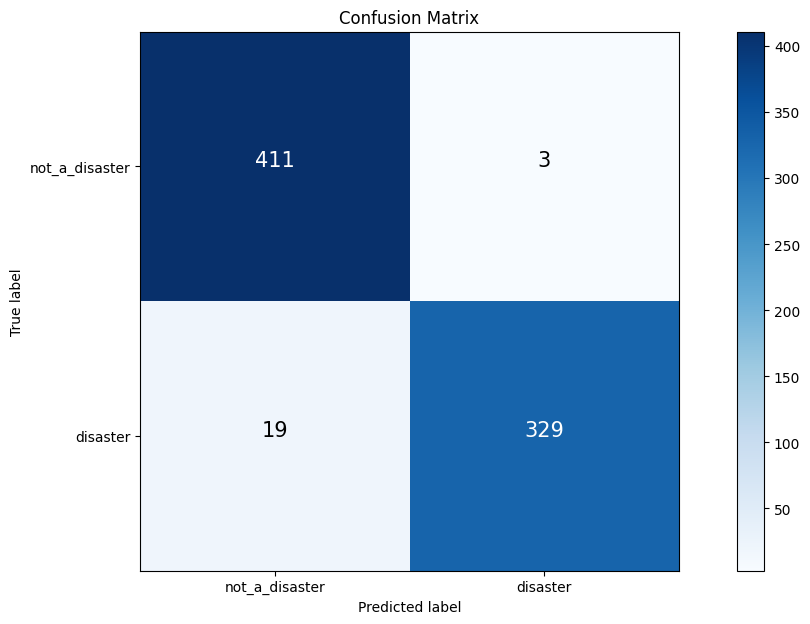

In [59]:
# Plotting the confusion matrix - model_uae_trainable
make_confusion_matrix(y_true=val_labels,
                      y_pred=model_uae_probs,
                      classes=class_names,
                      figsize=(15, 7),
                      norm = False,
                      savefig=True,
                      text_size=15)